In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import yfinance as yf
import requests
from yfinance import shared

In [2]:
from keras.models import Sequential
from keras.layers import SimpleRNN,Dense

In [3]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)

# نمایش GPU های شناسایی شده
gpus = tf.config.list_physical_devices('GPU')
print("Detected GPUs:", gpus)

TensorFlow version: 2.10.0
Detected GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
import torch
print("torch version:", torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.device_count())


torch version: 2.5.1
True
1


import yfinance as yf
import requests
from yfinance import shared

# Disable SSL verification (only for testing)
session = requests.Session()
session.verify = False  # Disable SSL certificate verification
shared._requests = session

ms_ds = yf.download('MSFT', start='2012-01-01', end='2021-12-31', auto_adjust=True, progress=False)
print(ms_ds.head())


In [6]:
ms_ds = yf.download('MSFT', start='2012-01-01', end='2021-12-31', auto_adjust=False, progress=False)

In [7]:
ms_ds

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT,MSFT
Date,,,,,,
2012-01-03,21.039213,26.770000,26.959999,26.389999,26.549999,64731500
2012-01-04,21.534338,27.400000,27.469999,26.780001,26.820000,80516100
2012-01-05,21.754395,27.680000,27.730000,27.290001,27.379999,56081400
2012-01-06,22.092352,28.110001,28.190001,27.530001,27.530001,99455500
2012-01-09,21.801556,27.740000,28.100000,27.719999,28.049999,59706800
...,...,...,...,...,...,...
2021-12-23,324.979797,334.690002,336.390015,332.730011,332.750000,19617800
2021-12-27,332.514709,342.450012,342.480011,335.429993,335.459991,19947000


In [8]:
print(ms_ds.columns)

MultiIndex([('Adj Close', 'MSFT'),
            (    'Close', 'MSFT'),
            (     'High', 'MSFT'),
            (      'Low', 'MSFT'),
            (     'Open', 'MSFT'),
            (   'Volume', 'MSFT')],
           names=['Price', 'Ticker'])


In [9]:
df = ms_ds[["Adj Close","Open", "Close", "High", "Low"]].round(3)
df.head(10)

Price,Adj Close,Open,Close,High,Low
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT
Date,,,,,
2012-01-03,21.039,26.55,26.77,26.96,26.39
2012-01-04,21.534,26.82,27.40,27.47,26.78
2012-01-05,21.754,27.38,27.68,27.73,27.29
2012-01-06,22.092,27.53,28.11,28.19,27.53
2012-01-09,21.802,28.05,27.74,28.10,27.72
2012-01-10,21.880,27.93,27.84,28.15,27.75
2012-01-11,21.786,27.43,27.72,27.98,27.37
2012-01-12,22.006,27.87,28.00,28.02,27.65


<Axes: xlabel='Date'>

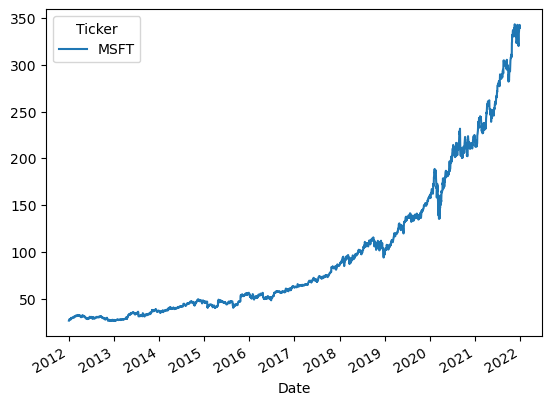

In [10]:
df.Close.plot()

In [11]:
df[:'2020'].Close.values.reshape(-1,1).shape

(2265, 1)

In [12]:
df['2021':].Close.values.reshape(-1,1).shape

(251, 1)

حال می خواهیم بر 6 تا 6تا بریم جلو براساس 6 تا 2 تا جلوی خودمونو پیش بینی کنیم که به صورت زیره

In [14]:
train_df = df[:'2020'].Close.values.reshape(-1,1)
test_df = df['2021':].Close.values.reshape(-1,1)
x_train =[]
y_train = []
y_step = 2
x_step = 6
for i in range(x_step,len(train_df)-y_step+1):
    x_train.append(train_df[i-x_step: i,0])
    y_train.append(train_df[i:i+y_step,0])

In [15]:
np.array(x_train).shape

(2258, 6)

In [16]:
np.array(y_train).shape

(2258, 2)

چک کنیم

In [18]:
train_df[:8,0]

array([26.77, 27.4 , 27.68, 28.11, 27.74, 27.84, 27.72, 28.  ])

In [19]:
x_train[0]

array([26.77, 27.4 , 27.68, 28.11, 27.74, 27.84])

In [20]:
y_train[0]

array([27.72, 28.  ])

از آخر چک کنیم 

In [22]:
train_df[-8:,0]

array([222.59, 223.94, 221.02, 222.75, 224.96, 224.15, 221.68, 222.42])

In [23]:
x_train[-1]

array([222.59, 223.94, 221.02, 222.75, 224.96, 224.15])

In [24]:
y_train[-1]

array([221.68, 222.42])

همون گارو برای تست ها انجام میدیم

In [26]:
X = df.Close.values
X = X[len(X)-len(test_df)-x_step:]
X = X.reshape(-1, 1)

In [27]:
x_test = []
y_test = []
for i in range (x_step,len(test_df)+x_step -y_step +1):
    x_test.append(X[i-x_step:i, 0])
    y_test.append(X[i:i+y_step, 0])


In [28]:
test_df[-8:,0]

array([319.91, 327.29, 333.2 , 334.69, 342.45, 341.25, 341.95, 339.32])

In [29]:
x_test[-1]

array([319.91, 327.29, 333.2 , 334.69, 342.45, 341.25])

In [30]:
y_test[-1]

array([341.95, 339.32])

همونارو توی یک تابع بنویسیم
* سخت نیستش فقط طولانیه

In [32]:
def ts_data(df, X_steps, y_steps):
  train_df = df[:"2020"].Close.values.reshape(-1, 1)
  test_df = df["2021":].Close.values.reshape(-1, 1)

  sc = MinMaxScaler(feature_range=(0, 1))
  train_df_scaled = sc.fit_transform(train_df)

  X_train = []
  y_train = []
  for i in range(X_steps, len(train_df_scaled)-y_steps+1):
    X_train.append(train_df_scaled[i-X_steps:i, 0])
    y_train.append(train_df_scaled[i:i+y_steps, 0])
  X_train = np.array(X_train)
  y_train = np.array(y_train)

  X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

  X = df.Close.values
  X = X[len(X)-len(test_df)-X_steps:]
  X = X.reshape(-1, 1)
  X = sc.transform(X)

  X_test = []
  y_test = []
  for i in range(X_steps, len(test_df)+X_steps-y_steps+1):
    X_test.append(X[i-X_steps:i, 0])
    y_test.append(X[i:i+y_steps, 0])

  X_test = np.array(X_test)
  X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
  y_test = np.array(y_test)

  return X_train, y_train, X_test, y_test, sc

برای فهم بیشتر مراجعه شود به فایل 
* sites\RNN داده_های سهام.html

In [34]:
df[:"2020"].Close.values.reshape(-1, 1).shape

(2265, 1)

In [35]:
X_train, y_train, X_test, y_test, sc = ts_data(df, 6, 2)

In [36]:
X_train.shape

(2258, 6, 1)

In [37]:
y_train.shape

(2258, 2)

In [38]:
X_test.shape

(250, 6, 1)

In [39]:
y_test.shape

(250, 2)

## simple RNN
* داده به فرمت مناسب برای شبکه های ترتیبی در اومده حالا به صورت زیر مدل را میسازیم

In [41]:
simple_rnn_model = Sequential([
    SimpleRNN(50,return_sequences=True),
    SimpleRNN(50),
    #return_sequences=True
    # اگر دیگه نمیخواهیم به لایه توالی دیگری یعنی سیمپل ار ن ن وصل کنیم دیگه نیاز به تورو بودن ندارد
    Dense(2)
])

In [42]:
simple_rnn_model.compile(optimizer="adam", loss="mean_squared_error")

In [43]:
simple_rnn_model.fit(X_train, y_train, epochs=100, validation_split=0.15)

Epoch 1/100
60/60 [==============================] - 4s 33ms/step - loss: 0.0115 - val_loss: 0.0234
Epoch 2/100
60/60 [==============================] - 2s 29ms/step - loss: 1.5186e-04 - val_loss: 0.0207
Epoch 3/100
60/60 [==============================] - 2s 26ms/step - loss: 1.3130e-04 - val_loss: 0.0169
Epoch 4/100
60/60 [==============================] - 2s 31ms/step - loss: 1.2656e-04 - val_loss: 0.0153
Epoch 5/100
60/60 [==============================] - 2s 29ms/step - loss: 1.0383e-04 - val_loss: 0.0119
Epoch 6/100
60/60 [==============================] - 2s 28ms/step - loss: 9.7851e-05 - val_loss: 0.0122
Epoch 7/100
60/60 [==============================] - 2s 28ms/step - loss: 8.6595e-05 - val_loss: 0.0089
Epoch 8/100
60/60 [==============================] - 2s 31ms/step - loss: 8.0632e-05 - val_loss: 0.0079
Epoch 9/100
60/60 [==============================] - 2s 28ms/step - loss: 8.3225e-05 - val_loss: 0.0070
Epoch 10/100
60/60 [==============================] - 2s 29ms/step -

## predicttion

In [45]:
df['2021':].index

DatetimeIndex(['2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07',
               '2021-01-08', '2021-01-11', '2021-01-12', '2021-01-13',
               '2021-01-14', '2021-01-15',
               ...
               '2021-12-16', '2021-12-17', '2021-12-20', '2021-12-21',
               '2021-12-22', '2021-12-23', '2021-12-27', '2021-12-28',
               '2021-12-29', '2021-12-30'],
              dtype='datetime64[ns]', name='Date', length=251, freq=None)

In [46]:
len(y_test)

250

In [47]:
simple_rnn_pred = simple_rnn_model.predict(X_test)

8/8 [==============================] - 0s 10ms/step


In [48]:
simple_rnn_pred.shape

(250, 2)

In [49]:
def prediction_plot(predictions):
    fig, ax = plt.subplots()
    ax.plot(df["2021":].index[:len(y_test)],
          sc.inverse_transform(y_test[:, 0].reshape(-1, 1)), label="Real")
    ax.plot(df["2021":].index[:len(y_test)],
          sc.inverse_transform(predictions[:, 0].reshape(-1, 1)), label="Prediction")
    plt.legend()
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title("Real vs Predicted Stock Price - 2021")
    plt.grid(True)
    plt.show()

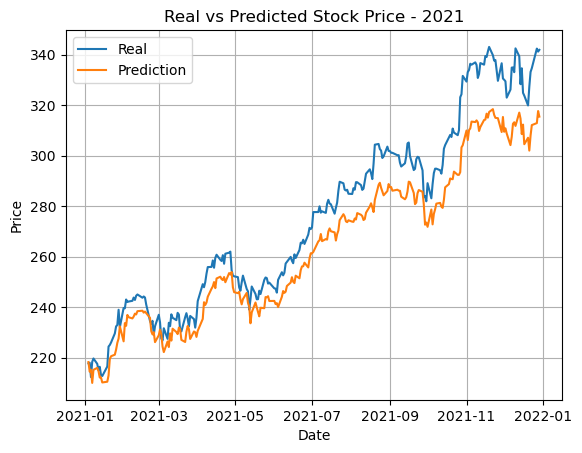

In [50]:
prediction_plot(simple_rnn_pred)

# lstm

In [52]:
from keras.layers import LSTM

In [53]:
lstm = Sequential([
                    LSTM(50, return_sequences=True),
                    LSTM(50),
                    Dense(2)
                  ])

In [54]:
lstm.compile(optimizer="adam", loss="mean_squared_error")

In [55]:
lstm.compile(optimizer="adam", loss="mean_squared_error")

In [56]:
lstm.fit(X_train, y_train, epochs=100, validation_split=0.15)

Epoch 1/100
60/60 [==============================] - 9s 33ms/step - loss: 0.0080 - val_loss: 0.0222
Epoch 2/100
60/60 [==============================] - 1s 15ms/step - loss: 1.3734e-04 - val_loss: 0.0031
Epoch 3/100
60/60 [==============================] - 1s 13ms/step - loss: 9.3018e-05 - val_loss: 0.0014
Epoch 4/100
60/60 [==============================] - 1s 12ms/step - loss: 8.0711e-05 - val_loss: 0.0010
Epoch 5/100
60/60 [==============================] - 1s 11ms/step - loss: 7.0123e-05 - val_loss: 0.0013
Epoch 6/100
60/60 [==============================] - 1s 12ms/step - loss: 6.6442e-05 - val_loss: 0.0012
Epoch 7/100
60/60 [==============================] - 1s 13ms/step - loss: 6.8065e-05 - val_loss: 0.0018
Epoch 8/100
60/60 [==============================] - 1s 13ms/step - loss: 6.5817e-05 - val_loss: 0.0012
Epoch 9/100
60/60 [==============================] - 1s 14ms/step - loss: 6.6497e-05 - val_loss: 0.0015
Epoch 10/100
60/60 [==============================] - 1s 12ms/step -

8/8 [==============================] - 1s 9ms/step


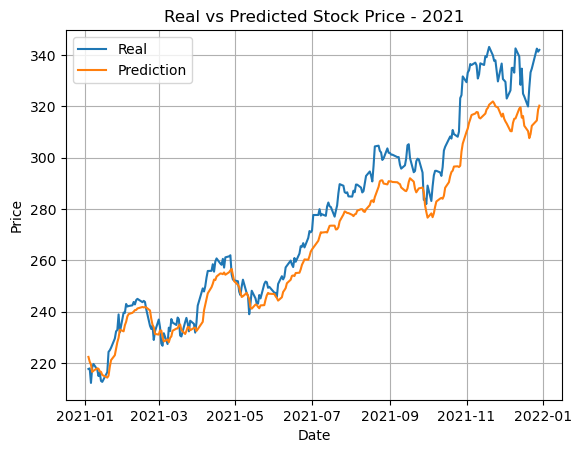

In [57]:
prediction_plot(lstm.predict(X_test))

# glounts (DEEP AR)

In [59]:
import gluonts
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas

In [60]:
print(df.Close[:'2020'].shape)
print(df.head())
print(df.index)

(2265, 1)
Price      Adj Close   Open  Close   High    Low
Ticker          MSFT   MSFT   MSFT   MSFT   MSFT
Date                                            
2012-01-03    21.039  26.55  26.77  26.96  26.39
2012-01-04    21.534  26.82  27.40  27.47  26.78
2012-01-05    21.754  27.38  27.68  27.73  27.29
2012-01-06    22.092  27.53  28.11  28.19  27.53
2012-01-09    21.802  28.05  27.74  28.10  27.72
DatetimeIndex(['2012-01-03', '2012-01-04', '2012-01-05', '2012-01-06',
               '2012-01-09', '2012-01-10', '2012-01-11', '2012-01-12',
               '2012-01-13', '2012-01-17',
               ...
               '2021-12-16', '2021-12-17', '2021-12-20', '2021-12-21',
               '2021-12-22', '2021-12-23', '2021-12-27', '2021-12-28',
               '2021-12-29', '2021-12-30'],
              dtype='datetime64[ns]', name='Date', length=2516, freq=None)


In [61]:
print(df.Close[:'2020'].shape)          # باید چیزی مثل (2265,) باشه
print(df.Close[:'2020'].values.shape)   # باید همون باشه
print(df.Close[:'2020'].values.squeeze().ndim)  # باید 1 بشه


(2265, 1)
(2265, 1)
1


In [62]:
train_data = ListDataset([
        {
        'start': df.index[0],
        'target': df.Close[:'2020'].values.squeeze()  # یا .flatten()
            }
                            ],
                         freq='D')


In [63]:
train_list_data = next(iter(train_data))
train_series = to_pandas(train_list_data)

In [64]:
train_series

2012-01-03     26.770000
2012-01-04     27.400000
2012-01-05     27.680000
2012-01-06     28.110001
2012-01-07     27.740000
                 ...    
2018-03-12    222.750000
2018-03-13    224.960007
2018-03-14    224.149994
2018-03-15    221.679993
2018-03-16    222.419998
Freq: D, Length: 2265, dtype: float32

In [65]:
train_series.values

array([ 26.77,  27.4 ,  27.68, ..., 224.15, 221.68, 222.42], dtype=float32)

<Axes: >

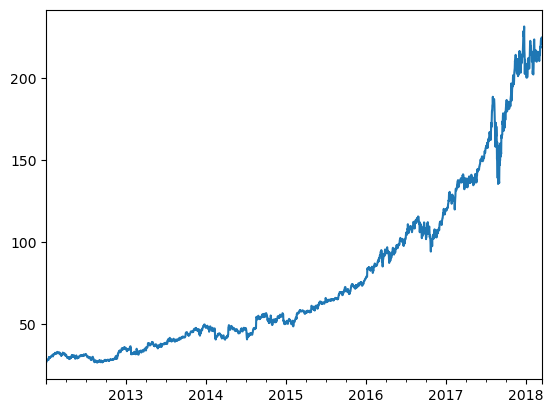

In [66]:
train_series.plot()

In [67]:
df.index = pd.to_datetime(df.index)

In [68]:
test_Data = ListDataset([
        {
        'start': df.index[0],
        'target': df.Close.values.squeeze()  # یا .flatten()
            }
                            ],
                         freq='D')


In [69]:
test_list_data = next(iter(test_Data))
test_seris_data = to_pandas(test_list_data)

In [70]:
test_seris_data.values

array([ 26.77,  27.4 ,  27.68, ..., 341.25, 341.95, 339.32], dtype=float32)

<Axes: >

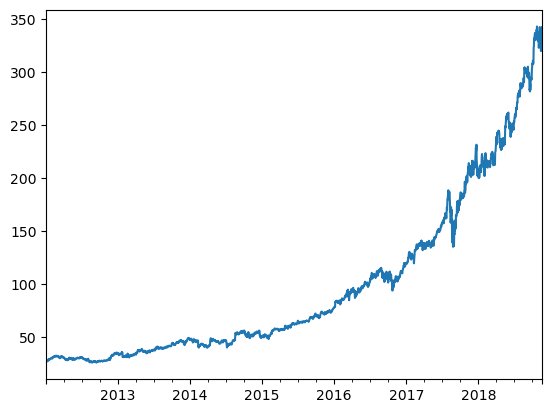

In [71]:
test_seris_data.plot()

In [72]:
from gluonts.torch.model.deepar import DeepAREstimator
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import Evaluator, make_evaluation_predictions

from lightning.pytorch import Trainer as PLTrainer
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor


In [73]:
# 🚀 تنظیمات بهینه‌شده مدل DeepAR
callbacks = [
    EarlyStopping(monitor="train_loss", patience=15, mode="min"),
    LearningRateMonitor(logging_interval='epoch')
]

In [74]:
from gluonts.torch.distributions.studentT import StudentTOutput
from gluonts.torch.distributions.distribution_output import NormalOutput

deepAR_model = DeepAREstimator(
    freq="D",                     # فرکانس داده‌های سری زمانی (مثلاً روزانه)
    prediction_length=5,         # چند روز آینده را پیش‌بینی کنیم
    context_length=20,           # چند روز گذشته برای آموزش مدل در نظر گرفته شود
    num_layers=6,                # تعداد لایه‌های LSTM
    hidden_size=150,             # اندازه‌ی مخفی هر لایه (ظرفیت مدل)
    dropout_rate=0.1,            # برای جلوگیری از overfitting
    distr_output=StudentTOutput(),  # توزیع خروجی برای داده‌های نوسانی بهتر از NormalOutput
    scaling=True,                # مقیاس‌بندی خودکار داده‌ها بسیار مهم است
    trainer_kwargs={             # پارامترهای مربوط به Trainer (lightning)
        "max_epochs": 30,                    # تعداد epochها برای آموزش
        "callbacks": callbacks,              # early stopping و lr monitor
        "accelerator": "auto",               # استفاده خودکار از GPU در صورت وجود
        "enable_model_summary": False,       # غیرفعال‌سازی خلاصه مدل
        "gradient_clip_val": 1.0,            # برای جلوگیری از گرادیان انفجاری
        "log_every_n_steps": 25,             # تعداد گام بین لاگ‌گیری‌ها
    }
)

In [75]:
import torch
# ⚙️ تنظیم دقیق برای محاسبات سریع‌تر
torch.set_float32_matmul_precision('high')

In [76]:
deepAR_model_predictator = deepAR_model.train(train_data)
#                          deepAR_model.train(train_data, validation_data=val_data)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\ProgramData\anaconda3\envs\ai\lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 4.26427 (best 4.26427), saving model to 'C:\\Users\\AERO\\Downloads\\Video\\projects\\lightning_logs\\version_21\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 2.56640 (best 2.56640), saving model to 'C:\\Users\\AERO\\Downloads\\Video\\projects\\lightning_logs\\version_21\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' was not in top 1
Epoch 3, global step 200: 'train_loss' reached 2.17349 (best 2.17349), saving model to 'C:\\Users\\AERO\\Downloads\\Video\\projects\\lightning_logs\\version_21\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global step 350: 'train_loss' was not in top 1
Epoch 7, global step 400: 'train_loss' was not in top 1
Epoch 8, global step 450: 'train_loss' was not in top 1
Epoch 9, global step 500: 'train_loss' reached 2

In [77]:
from gluonts.evaluation import make_evaluation_predictions

In [78]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_Data,  # test dataset
    predictor=deepAR_model_predictator,  # predictor
    num_samples=300,  # number of sample paths we want for evaluation
)

In [79]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [80]:
ts_entry = tss[0]

In [81]:
forecast_entry = forecasts[0]

In [82]:
forecast_entry.samples.shape

(300, 5)

In [83]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

def plot_prob_forecasts_improved(ts_entry, forecast_entry, plot_length=15, figsize=(12, 8)):
    if len(ts_entry) < plot_length:
        plot_length = len(ts_entry)
        print(f"⚠️ Warning: plot_length adjusted to {plot_length}")

    fig, ax = plt.subplots(figsize=figsize)
    historical_data = ts_entry[-plot_length:]

    # اگر PeriodIndex بود، به Timestamp تبدیل کن
    if isinstance(historical_data.index, pd.PeriodIndex):
        historical_data.index = historical_data.index.to_timestamp()

    ax.plot(historical_data.index, historical_data.values, 
            color='#2E86AB', linewidth=2.5, label='Observations', marker='o', markersize=4)

    try:
        median = forecast_entry.quantile(0.5)
        p50_lower = forecast_entry.quantile(0.25)
        p50_upper = forecast_entry.quantile(0.75)
        p90_lower = forecast_entry.quantile(0.05)
        p90_upper = forecast_entry.quantile(0.95)

        # استفاده مستقیم از forecast_entry.freq
        prediction_index = pd.date_range(
            start=forecast_entry.start_date.to_timestamp() 
                  if isinstance(forecast_entry.start_date, pd.Period) 
                  else forecast_entry.start_date,
            periods=len(median),
            freq=forecast_entry.freq
        )

        ax.fill_between(prediction_index, p90_lower, p90_upper, 
                       color='#A8DADC', alpha=0.3, label='90% Prediction Interval')
        ax.fill_between(prediction_index, p50_lower, p50_upper, 
                       color='#457B9D', alpha=0.5, label='50% Prediction Interval')
        ax.plot(prediction_index, median, color='#E63946', linewidth=2.5, 
                label='Median Prediction', marker='s', markersize=4)

        forecast_mean = np.mean(median)
        historical_mean = np.mean(historical_data.values)
        trend_change = forecast_mean - historical_data.values[-1]

        print("📊 Forecast Analysis:")
        print(f"   Last Historical Value: {float(historical_data.values[-1]):.2f}")
        print(f"   Forecast Mean: {float(forecast_mean):.2f}")
        print(f"   Trend Change: {float(trend_change):+.2f}")
        print(f"   Historical Mean: {float(historical_mean):.2f}")


        interval_width_50 = np.mean(p50_upper - p50_lower)
        interval_width_90 = np.mean(p90_upper - p90_lower)
        historical_std = np.std(historical_data.values)

        print(f"\n🔍 Uncertainty Analysis:")
        print(f"   50% Interval Width: {interval_width_50:.2f}")
        print(f"   90% Interval Width: {interval_width_90:.2f}")
        print(f"   Historical Std: {historical_std:.2f}")
        if interval_width_90 < historical_std:
            print("   ⚠️ Warning: Model may be overconfident!")

    except Exception as e:
        print(f"❌ Error in processing forecast: {e}")
        return fig, ax

    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc="upper left", frameon=True, fancybox=True, shadow=True)
    ax.set_xlabel('Date', fontsize=12, fontweight='bold')
    ax.set_ylabel('Value', fontsize=12, fontweight='bold')
    ax.set_title('Time Series Forecasts with Confidence Intervals', 
                 fontsize=14, fontweight='bold', pad=20)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    ax.axvline(x=historical_data.index[-1], color='gray', linestyle=':', alpha=0.7, linewidth=1)
    ax.text(historical_data.index[-1], ax.get_ylim()[1]*0.95, 
            'Forecast Start', rotation=90, ha='right', va='top', 
            fontsize=10, alpha=0.7)

    plt.tight_layout()
    return fig, ax

def diagnose_forecast_quality(ts_entry, forecast_entry, plot_length=15):
    print("🔬 Model Diagnosis:")
    print("=" * 50)
    try:
        historical_data = ts_entry[-plot_length:]
        if isinstance(historical_data.index, pd.PeriodIndex):
            historical_data.index = historical_data.index.to_timestamp()
        median = forecast_entry.quantile(0.5)
        historical_trend = float(historical_data.values[-1] - historical_data.values[0])
        forecast_trend = float(median[-1] - median[0]) if len(median) > 1 else 0.0

        print(f"📈 Trend Analysis:")
        print(f"   Historical Trend: {historical_trend:+.2f}")
        print(f"   Forecast Trend: {forecast_trend:+.2f}")
        if abs(historical_trend) > 5 and abs(forecast_trend) < 1:
            print("   ⚠️ WARNING: Model not capturing recent trend!")

        historical_volatility = np.std(historical_data.values)
        p90_lower = forecast_entry.quantile(0.05)
        p90_upper = forecast_entry.quantile(0.95)
        forecast_uncertainty = float(np.mean(p90_upper - p90_lower))

        print(f"\n📊 Volatility Analysis:")
        print(f"   Historical Volatility: {historical_volatility:.2f}")
        print(f"   Forecast Uncertainty: {forecast_uncertainty:.2f}")
        if forecast_uncertainty < historical_volatility * 0.5:
            print("   ⚠️ WARNING: Model may be overconfident!")

        print(f"\n💡 Recommendations:")
        if abs(historical_trend) > 5 and abs(forecast_trend) < 1:
            print("   - Consider using trend-aware models (Prophet, ARIMA with trend)")
            print("   - Check if recent data is included in training")
        if forecast_uncertainty < historical_volatility * 0.5:
            print("   - Increase model uncertainty (adjust hyperparameters)")
            print("   - Consider ensemble methods")
    except Exception as e:
        print(f"❌ Error in diagnosis: {e}")

def enhanced_forecast_analysis(ts_entry, forecast_entry, plot_length=15):
    print("🚀 Enhanced Forecast Analysis")
    print("=" * 50)
    fig, ax = plot_prob_forecasts_improved(ts_entry, forecast_entry, plot_length)
    diagnose_forecast_quality(ts_entry, forecast_entry, plot_length)
    plt.show()
    return fig, ax


🚀 Enhanced Forecast Analysis
📊 Forecast Analysis:
   Last Historical Value: 339.32
   Forecast Mean: 340.93
   Trend Change: +1.61
   Historical Mean: 333.79

🔍 Uncertainty Analysis:
   50% Interval Width: 9.53
   90% Interval Width: 29.01
   Historical Std: 7.22
🔬 Model Diagnosis:
📈 Trend Analysis:
   Historical Trend: +6.22
   Forecast Trend: +0.75
   ⚠️ WARNING: Model not capturing recent trend!

📊 Volatility Analysis:
   Historical Volatility: 7.22
   Forecast Uncertainty: 29.01

💡 Recommendations:
   - Consider using trend-aware models (Prophet, ARIMA with trend)
   - Check if recent data is included in training


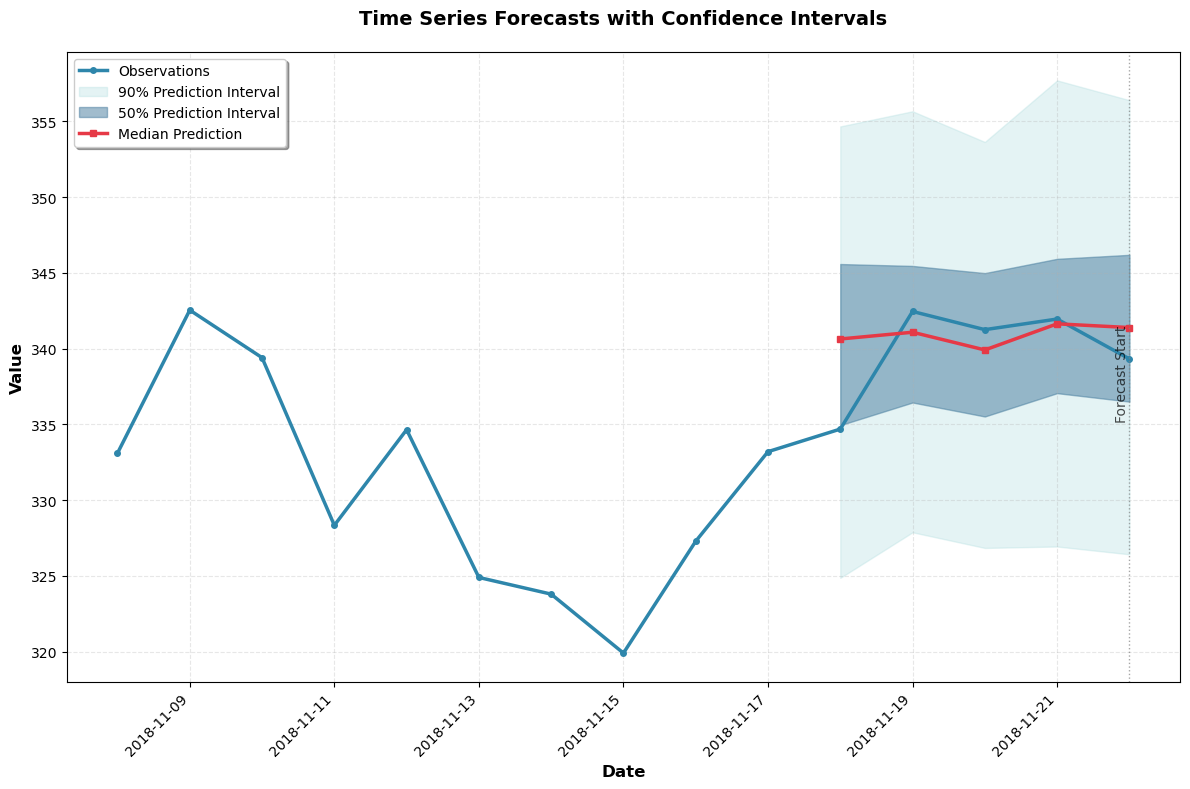

(<Figure size 1200x800 with 1 Axes>,
 <Axes: title={'center': 'Time Series Forecasts with Confidence Intervals'}, xlabel='Date', ylabel='Value'>)

In [84]:
# فراخوانی:
enhanced_forecast_analysis(ts_entry, forecast_entry)

# DARTS

In [8]:
import darts

In [9]:
import darts.utils.timeseries_generation as tg 
from darts.models import RNNModel
from darts.utils.likelihood_models import GaussianLikelihood
from darts.datasets import EnergyDataset, AirPassengersDataset
from darts.dataprocessing.transformers import Scaler
from darts.utils.missing_values import fill_missing_values
from darts import TimeSeries
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from pandas import Timestamp

C:\ProgramData\anaconda3\envs\ai\lib\site-packages\fs\__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore


In [12]:
signal_length = 400

signal_series = tg.linear_timeseries(
    start_value=0,
    end_value=4,
    start=None,
    end=Timestamp('2020-01-01 00:00:00'),
    length=signal_length,
    freq='D',
    column_name='Close'
)

In [14]:
signal_series

<TimeSeries (time: 400, component: 1, sample: 1)> Size: 3kB
array([[[0.        ]],

       [[0.01002506]],

       [[0.02005013]],

       [[0.03007519]],

       [[0.04010025]],

       [[0.05012531]],

       [[0.06015038]],

       [[0.07017544]],

       [[0.0802005 ]],

       [[0.09022556]],

...

       [[3.90977444]],

       [[3.9197995 ]],

       [[3.92982456]],

       [[3.93984962]],

       [[3.94987469]],

       [[3.95989975]],

       [[3.96992481]],

       [[3.97994987]],

       [[3.98997494]],

       [[4.        ]]])
Coordinates:
  * time       (time) datetime64[ns] 3kB 2018-11-28 2018-11-29 ... 2020-01-01
  * component  (component) object 8B 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

In [16]:
signal_series.values().shape

(400, 1)

In [18]:
signal_series.all_values().shape

(400, 1, 1)

### ساخت داده مصنوعی 

<Axes: xlabel='time'>

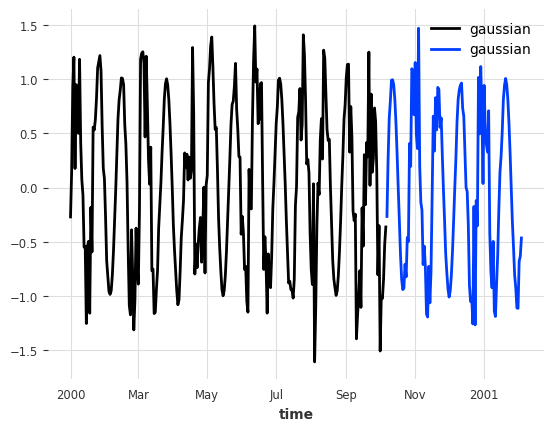

In [21]:
# طول سری زمانی را مشخص می‌کنیم (تعداد نقاط داده)
signal_length = 400

# تولید سری زمانی خطی (trend) از مقدار اولیه به سمت 4 در طول 400 نقطه
signal_trend = tg.linear_timeseries(length=signal_length, end_value=4)

# تولید سیگنال سینوسی با فرکانس 0.05 و دامنه 1.0
sine_signal = tg.sine_timeseries(length=signal_length,
                                 value_frequency=0.05,
                                 value_amplitude=1.0)

# تولید نویز گوسی (Gaussian noise) با انحراف معیار 0.5
noise = tg.gaussian_timeseries(length=signal_length, std=0.5)

# تولید نویز نوسانی ضعیف که مقدارش بین 0.5 تا 1.5 نوسان دارد
noise_sine = (
    tg.sine_timeseries(length=signal_length, value_frequency=0.02) +  # سیگنال سینوسی کند
    tg.constant_timeseries(length=signal_length, value=1)             # مقدار ثابت ۱
) / 2  # میانگین این دو (نویز با دامنه متغیر)

# ضرب نویز اصلی در نویز نوسانی برای ساخت نویز پیچیده‌تر
noise = noise * noise_sine

# جمع نویز و سیگنال سینوسی برای ساخت سیگنال هدف نهایی (target series)
target_series = sum([noise, sine_signal])

# تقسیم داده به دو بخش: آموزش (۷۰٪ اول) و اعتبارسنجی (۳۰٪ پایانی)
target_train, target_val = target_series.split_after(0.7)

# رسم نمودار داده‌های آموزشی
target_train.plot()

# رسم نمودار داده‌های اعتبارسنجی
target_val.plot()


## ساخت مدل

In [24]:
rnn_model = RNNModel(
    model="LSTM",
    hidden_dim=30,
    n_rnn_layers=5,
    dropout=0.2,
    n_epochs=15,
    optimizer_kwargs={"lr":1e-3},
    input_chunk_length=20,
    training_length=50,
    likelihood=GaussianLikelihood(),

)

In [ ]:
rnn_model.fit(series=target_train, val_series=target_val)


## پیش بینی مدل برای 50 روز آینده

In [28]:
rnn_model.predict(50, num_samples=50).all_values().shape

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

(50, 1, 50)

In [29]:
rnn_model.predict(50, num_samples=50)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

<TimeSeries (time: 50, component: 1, sample: 50)> Size: 20kB
array([[[ 0.03087926, -0.46651306,  0.35739591, ..., -0.01956485,
          0.19287664,  0.53758551]],

       [[ 0.12371953,  0.4781481 ,  0.68144367, ...,  1.70078069,
          0.25101203, -0.41871888]],

       [[ 0.34119012,  1.24828234,  0.66046177, ...,  0.44160817,
          0.13738656,  1.06480072]],

       ...,

       [[ 0.79237832,  0.45253216,  0.59638213, ...,  0.43750875,
         -0.03946164,  1.12497039]],

       [[ 0.08895538,  0.8892714 ,  0.4860895 , ...,  0.74864852,
          0.45686555,  0.63513579]],

       [[-0.36997788, -0.18284236, -0.23600581, ...,  0.59353077,
         -0.37389029,  0.45672975]]])
Coordinates:
  * time       (time) datetime64[ns] 400B 2000-10-07 2000-10-08 ... 2000-11-25
  * component  (component) object 8B 'gaussian'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

In [30]:
pred = rnn_model.predict(50, num_samples=50)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: xlabel='time'>

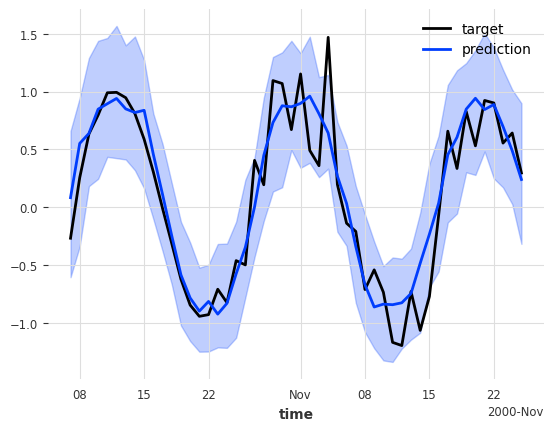

In [31]:
target_val.slice_intersect(pred).plot(label='target')
pred.plot(label='prediction')

### یک دیتاست جدید

In [33]:
energy_df = EnergyDataset().load().to_dataframe()

In [34]:
energy_df

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
time,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
2015-01-01 00:00:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,NaN,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2015-01-01 01:00:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,NaN,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
2015-01-01 02:00:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,NaN,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
2015-01-01 03:00:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,NaN,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 18:00:00,297.0,0.0,0.0,7634.0,2628.0,178.0,0.0,0.0,0.0,NaN,...,277.0,0.0,3113.0,96.0,NaN,3253.0,30619.0,30653.0,68.85,77.02
2018-12-31 19:00:00,296.0,0.0,0.0,7241.0,2566.0,174.0,0.0,0.0,0.0,NaN,...,280.0,0.0,3288.0,51.0,NaN,3353.0,29932.0,29735.0,68.40,76.16
2018-12-31 20:00:00,292.0,0.0,0.0,7025.0,2422.0,168.0,0.0,0.0,0.0,NaN,...,286.0,0.0,3503.0,36.0,NaN,3404.0,27903.0,28071.0,66.88,74.30


چون هر دو ساعت یکباره به جای روزانه ما میانگین روزانه را در نظر می گیریم

In [36]:
energy_df_daily = energy_df.groupby(energy_df.index.astype(str).str.split(' ').str[0]).mean().reset_index()

In [37]:
energy_df_daily

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2014-12-31,447.000000,329.000000,0.0,4844.000000,4821.000000,162.000000,0.0,0.0,0.0,...,196.000000,0.0,6378.000000,17.000000,NaN,6436.000000,26118.000000,25385.000000,50.100000,65.410000
1,2015-01-01,425.208333,243.708333,0.0,4187.791667,4099.458333,161.500000,0.0,0.0,0.0,...,201.041667,0.0,3994.000000,1049.500000,NaN,3942.416667,24753.250000,23966.958333,45.031667,62.090833
2,2015-01-02,389.875000,0.000000,0.0,3566.166667,1258.125000,200.833333,0.0,0.0,0.0,...,186.583333,0.0,11060.041667,1187.208333,NaN,11117.041667,27519.416667,27188.541667,17.598333,69.443750
3,2015-01-03,436.875000,0.000000,0.0,3451.791667,1375.958333,229.791667,0.0,0.0,0.0,...,202.333333,0.0,9137.250000,1133.375000,NaN,9113.416667,25500.833333,25097.750000,25.342083,65.223333
4,2015-01-04,396.375000,13.583333,0.0,3526.125000,2315.291667,356.625000,0.0,0.0,0.0,...,159.125000,0.0,8016.125000,2292.041667,NaN,8022.833333,27167.875000,27104.916667,30.658333,58.912083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1457,2018-12-27,304.666667,701.041667,0.0,9768.750000,2901.125000,297.000000,0.0,0.0,0.0,...,297.541667,0.0,1115.916667,707.375000,NaN,1300.083333,28856.500000,28551.708333,67.585417,72.959583
1458,2018-12-28,316.291667,632.000000,0.0,7994.166667,2745.625000,273.458333,0.0,0.0,0.0,...,306.833333,0.0,4111.250000,743.958333,NaN,4226.208333,28553.416667,28661.166667,63.546667,69.230417
1459,2018-12-29,288.500000,0.000000,0.0,4972.458333,1716.208333,253.375000,0.0,0.0,0.0,...,310.750000,0.0,7156.958333,673.333333,NaN,6665.833333,26427.166667,26603.958333,57.085833,62.623333
1460,2018-12-30,275.333333,0.000000,0.0,5293.208333,1520.916667,224.083333,0.0,0.0,0.0,...,311.250000,0.0,4924.583333,1021.583333,NaN,4989.583333,25278.416667,25238.500000,58.552917,64.567083


# Complete and Professional Table of **All Arguments of `TimeSeries.from_dataframe()`** and **`fill_missing_values()`** in the Darts Library, with Detailed Explanations  

***

## 🧩 Full Table of Arguments for `TimeSeries.from_dataframe()`

| Argument              | Type                                        | Default     | Description                                                                 |
| --------------------- | ------------------------------------------- | ----------- | --------------------------------------------------------------------------- |
| `df`                  | `pd.DataFrame`                              | –           | The input dataframe containing timestamps and data                          |
| `time_col`            | `str`                                       | `None`      | Name of the column containing time or dates                                 |
| `value_cols`          | `str` or `list`                             | `None`      | Column or columns containing the time series values                         |
| `freq`                | `str`                                       | `None`      | Data frequency, e.g., `'D'` for daily, `'H'` for hourly                     |
| `fill_missing_dates`  | `bool`                                      | `False`     | If `True`, missing timestamps will be filled                                |
| `fillna_value`        | `float`, `int`, `str`, or `None`            | `None`      | Replacement value for filling NaN entries in the data values                 |
| `static_covariates`   | `pd.Series`, `pd.DataFrame`, or `None`      | `None`      | Fixed features for the entire series (e.g., country, power plant type, etc.)|
| `hierarchy`           | `dict` or `None`                            | `None`      | Hierarchical structure of the data (for multi-level use cases)              |
| `metadata`            | `dict` or `None`                            | `None`      | Optional metadata for the time series (e.g., ID or custom description)      |
| `copy`                | `bool`                                      | `True`      | If `True`, input data will be copied (safer but slightly slower)            |

***

## 🔧 Table of Arguments for `fill_missing_values()`

| Argument | Type                      | Default   | Description                                                                 |
| -------- | ------------------------- | --------- | --------------------------------------------------------------------------- |
| `series` | `TimeSeries`              | –         | Input time series whose missing values you want to fill                     |
| `fill`   | `str`, `float`, or `int`  | `'auto'`  | How to fill missing values:                                                 |
|          | `'auto'`                  |           | Automatically selects the best method                                      |
|          | `'linear'`                |           | Linear interpolation between available values                               |
|          | `'last'`                  |           | Carries forward the last available value                                   |
|          | `'mean'`                  |           | Uses the overall mean value                                                |
|          | numeric value (e.g., `0`) |           | A specific numeric value to replace NaNs with                              |

***

## ✅ Pro Tips:

* If your data contains missing timestamps (e.g., some days are not recorded), you should use `fill_missing_dates=True` together with `freq='D'`.  
* If your model relies on static covariates (such as N-HiTS or RNN with static features), `static_covariates` becomes very useful.  
* `metadata` is helpful for tracking, logging, or tagging series, especially in large projects.  


حالا که تبدیل به وزانه شدن باید به فرمت تایم سریز تبدیل کنیم

In [40]:
energy_ts_daily = fill_missing_values(
    TimeSeries.from_dataframe(
    df=energy_df_daily,
    time_col = 'time',
    value_cols = ['generation hydro run-of-river and poundage'],
    # fill_missing_dates: Optional[bool] = True,
    freq= 'D',
    # fillna_value: Optional[float] = 1
    )
    ,fill = 'auto')

In [41]:
energy_ts_daily = energy_ts_daily.astype(np.float32)

In [42]:
energy_ts_daily

<TimeSeries (time: 1462, component: 1, sample: 1)> Size: 6kB
array([[[1051.    ]],

       [[1056.9166]],

       [[1300.    ]],

       ...,

       [[1117.125 ]],

       [[1066.3334]],

       [[1063.0435]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 12kB 2014-12-31 2015-01-01 ... 2018-12-31
  * component  (component) object 8B 'generation hydro run-of-river and pound...
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

حالا باید اسکیل کنیم 

In [44]:
scaler_ts = Scaler()

In [45]:
energy_ts_daily_transform = scaler_ts.fit_transform(energy_ts_daily)

In [46]:
energy_ts_daily_transform

<TimeSeries (time: 1462, component: 1, sample: 1)> Size: 6kB
array([[[0.45423353]],

       [[0.45800972]],

       [[0.6131528 ]],

       ...,

       [[0.49643654]],

       [[0.46401978]],

       [[0.46192002]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 12kB 2014-12-31 2015-01-01 ... 2018-12-31
  * component  (component) object 8B 'generation hydro run-of-river and pound...
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

<Axes: xlabel='time'>

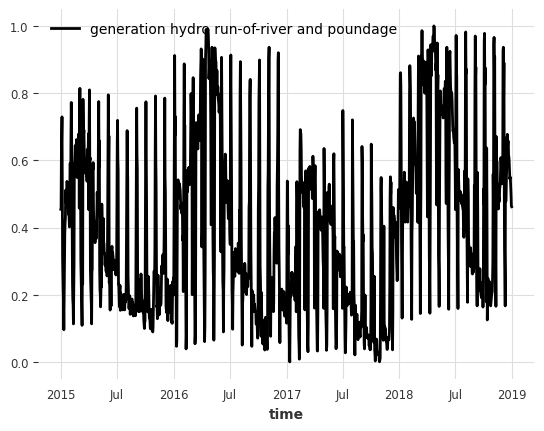

In [50]:
energy_ts_daily_transform.plot()

In [55]:
train_ts , val_ts = energy_ts_daily_transform.split_after(pd.Timestamp('20170901'))

ما اینجا نیاز به یک
* covariate  
داریم که به سری زمانی ما کمک کنه  با استفاده از متد زیر درستش میکنیم

In [67]:
datetime_attribute_timeseries(time_index =energy_ts_daily_transform,
    attribute = 'day',
    one_hot = True,
    cyclic= False,
    dtype= np.float32).to_dataframe()

,day_0,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,...,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30
time,,,,,,,,,,,,,,,,,,,,,
2014-12-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2015-01-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-02,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-03,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-04,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2018-12-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2018-12-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


همون بالایس فقط به دیتا فریم تبدیل نکریدم برای استفاده 

In [70]:
future_covariate = datetime_attribute_timeseries(time_index =energy_ts_daily_transform,
    attribute = 'day',
    one_hot = True,
    cyclic= False,
    dtype= np.float32)

In [72]:
scaler_cov = Scaler()

In [74]:
future_covariate_transform = scaler_cov.fit_transform(future_covariate)

In [76]:
train_cov , val_cov = future_covariate_transform.split_after(pd.Timestamp('20170901'))

حالا که داده های ما به سری زمانی تبدیل شد و بعدش استاندارد کردیم و بعد کوریشن هارو هم پیدا کریدم و باز استاندارد کریدم حالا باید مدلمونو بسازیم

from darts.models import RNNModel

In [80]:
enery_rnn_model = RNNModel(
    model="LSTM",
    hidden_dim=30,
    n_rnn_layers=3,
    dropout=0.2,
    n_epochs=20,
    optimizer_kwargs={"lr":1e-3},
    input_chunk_length=60,  # ← اکنون کوچک‌تر از طول داده ارزیابی
    training_length=80,
    likelihood=GaussianLikelihood()
)


In [ ]:
enery_rnn_model.fit(series=train_ts,future_covariates =train_cov)

# historical_forecast و backtest 

حالا چون ما نمی تونیم اینجا از 
* cross validation 
استفاده کنیم از متد زیر که توضیح دادم استفاده میکنیم

In [85]:
historical_forecasts_energy = enery_rnn_model.historical_forecasts(
                                    series=energy_ts_daily_transform,
                                    future_covariates=future_covariate_transform,
                                    num_samples=50,
                                    start=0.5,
                                    forecast_horizon=30,
                                    retrain=False,
                                    stride=5,
                                    last_points_only=False  # 👈 مهم
                                    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [86]:
print(f"تعداد پیش‌بینی‌ها: {len(historical_forecasts_energy)}")


تعداد پیش‌بینی‌ها: 141


In [87]:
from darts.metrics import mape, mae

# اجرای backtest با متریک MAE
mae_score = enery_rnn_model.backtest(
    series=energy_ts_daily_transform,
    future_covariates=future_covariate_transform,
    historical_forecasts=historical_forecasts_energy,
    metric=mae,
    retrain=False,
    verbose=True,
    last_points_only=False  # 👈 با گزینه بالا همخوانی دارد
)

In [88]:
print("MAE:", mae_score)

MAE: 0.15634730757868037


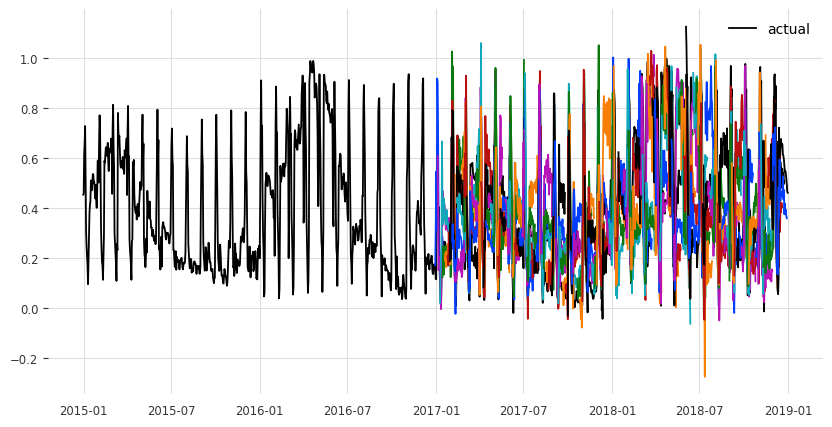

In [131]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(energy_ts_daily_transform.time_index, energy_ts_daily_transform.values(), label="actual")
for i, forecast in enumerate(historical_forecasts_energy):
    plt.plot(forecast.time_index, forecast.values())
plt.legend()
plt.show()


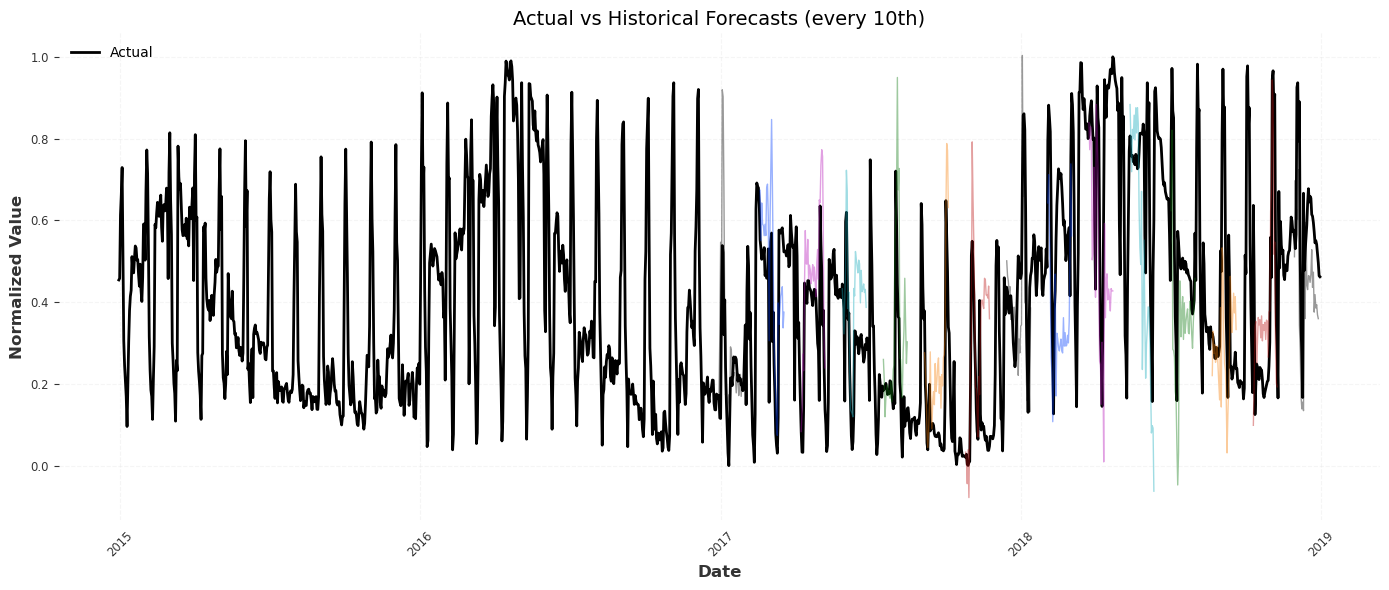

In [159]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(14, 6))

# سری واقعی
plt.plot(energy_ts_daily_transform.time_index, energy_ts_daily_transform.values(),
         label="Actual", color="black", linewidth=2)

# پیش‌بینی‌ها با گام فاصله
for i, forecast in enumerate(historical_forecasts_energy[::10]):  # هر 10 تای یکی
    plt.plot(forecast.time_index, forecast.values(), alpha=0.4, linewidth=1)

# تنظیمات نمودار
plt.title("Actual vs Historical Forecasts (every 10th)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Normalized Value", fontsize=12)

# تاریخ‌های زیباتر
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

# شبکه و توضیحات
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(loc='upper left', fontsize='medium')
plt.tight_layout()
plt.show()


In [149]:
import matplotlib.pyplot as plt
import numpy as np

def plot_forecasts_custom(actual_series, forecast_list, every_n=10, quantile_bands=False):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(30, 6))
    plt.plot(actual_series.time_index, actual_series.values(), label='Actual', color='black')

    for i, forecast in enumerate(forecast_list[::every_n]):
        try:
            if quantile_bands and forecast.n_samples > 1:
                q_hi = forecast.quantile(0.95)
                q_lo = forecast.quantile(0.05)
                plt.fill_between(
                    forecast.time_index,
                    q_lo.values().squeeze(),
                    q_hi.values().squeeze(),
                    color="gray",
                    alpha=0.2
                )
        except:
            pass  # در صورت نبودن امکان محاسبه quantile، فقط سری را رسم کن

        plt.plot(forecast.time_index, forecast.values(), label=f'Forecast {i*every_n}', alpha=0.6)

    plt.title("Actual vs Historical Forecasts")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend(loc='upper left', fontsize='small')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


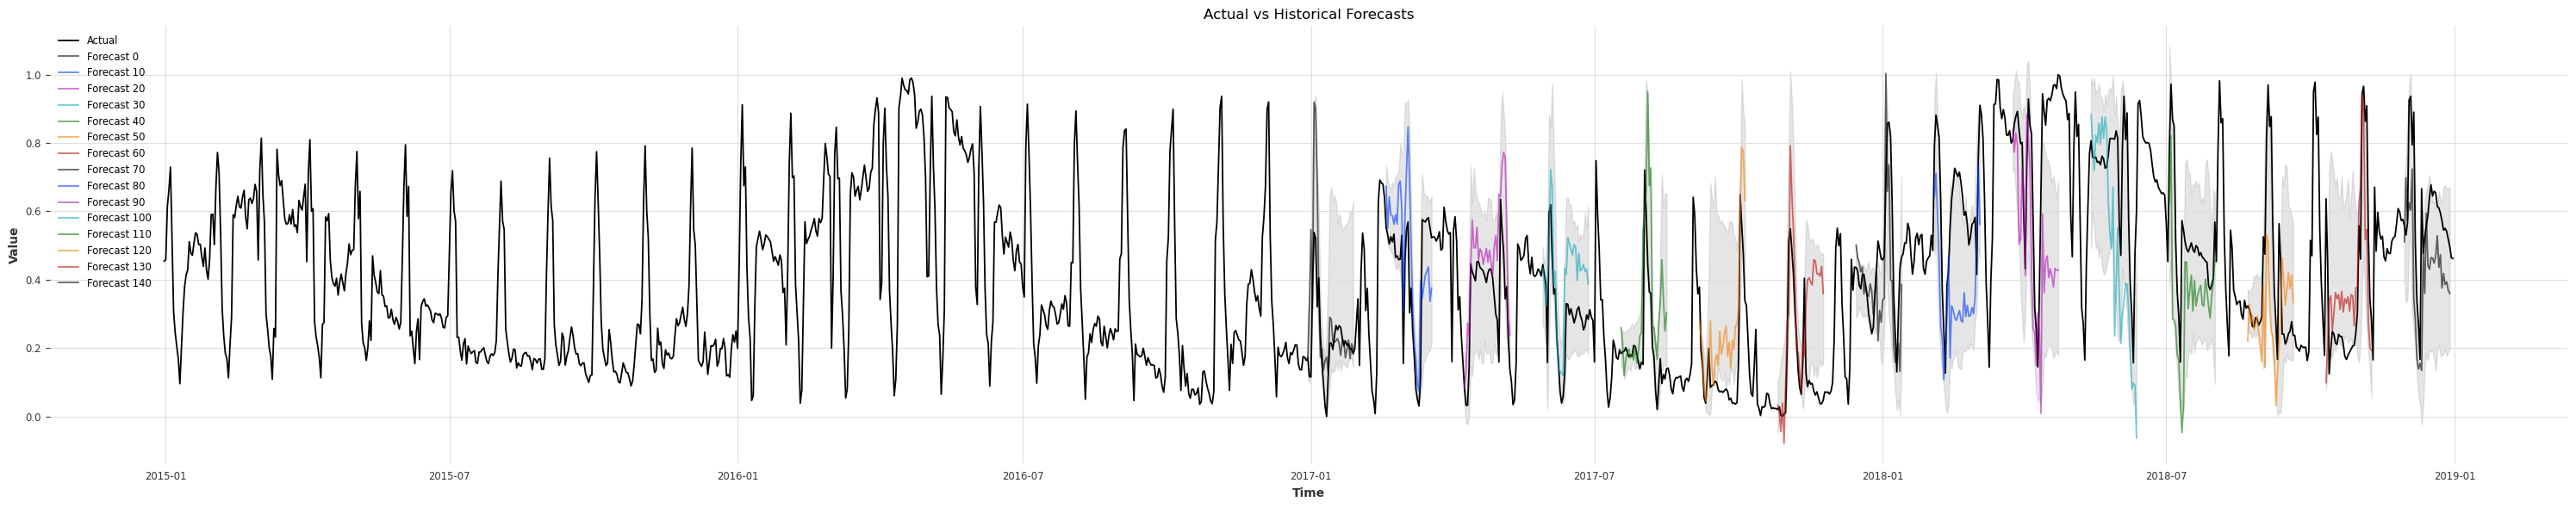

In [151]:
plot_forecasts_custom(
    actual_series=energy_ts_daily_transform,
    forecast_list=historical_forecasts_energy,
    every_n=10,            # هر ده تا یکی
    quantile_bands=True    # نمایش بازه پیش‌بینی
)
